# validation accuracy: 99.06%(원 논문) -> 99.14%
- 수정 사항: 입력 채널 및 출력부
- 기존 모델 최종 출력: CNN2D (256, num_classes), activation funciton 사용하지 않고, Loss function 적용
- 수정 후: 학습률 조정: Dense layer (1), sigmoid 사용, flatten 이후 dropout(0.25)추가
- learning rate 조정(rescheduler 추가), l2 reg 추가, batch_size = 256


## 고려사항

**학습률, loss 너무 오락가락**

**Rescheduler**

**Import Libraries**

In [1]:
import numpy as np
import pandas as pd

import psutil
import GPUtil

import os,sys,humanize,psutil,GPUtil

import matplotlib.pyplot as plt
import seaborn as sn
from PIL import Image
import matplotlib.image as mpimg
import imageio
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

**Memory Utilization Checkup (Before/After Model Execution)**

In [2]:
#CPU AND GPU LIBRARIES INSTALLATION (if you find error on import of psutil and GPUtil, please refer below)
!pip install psutil
!pip install GPUtil

In [3]:
#CPU MEMORY UTILIZATION

!cat /proc/meminfo

MemTotal:       16308040 kB
MemFree:         6842924 kB
MemAvailable:   10251072 kB
Buffers:          462548 kB
Cached:          2991224 kB
SwapCached:        43800 kB
Active:          2704140 kB
Inactive:        5634332 kB
Active(anon):     592548 kB
Inactive(anon):  4479364 kB
Active(file):    2111592 kB
Inactive(file):  1154968 kB
Unevictable:          16 kB
Mlocked:              16 kB
SwapTotal:       2097148 kB
SwapFree:        1441804 kB
Dirty:              1040 kB
Writeback:            16 kB
AnonPages:       4850460 kB
Mapped:           710508 kB
Shmem:            187212 kB
KReclaimable:     482044 kB
Slab:             688612 kB
SReclaimable:     482044 kB
SUnreclaim:       206568 kB
KernelStack:       28144 kB
PageTables:        92088 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:    10251168 kB
Committed_AS:   29317880 kB
VmallocTotal:   34359738367 kB
VmallocUsed:      111028 kB
VmallocChunk:          0 kB
Percpu:          

In [4]:
!grep MemTotal /proc/meminfo

MemTotal:       16308040 kB


In [5]:
#GPU MEMORY UTILIZATION 
!nvidia-smi --query-gpu=memory.total --format=csv

memory.total [MiB]
11264 MiB


In [6]:
# Function
def mem_report():
  print("CPU RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ))
  
  GPUs = GPUtil.getGPUs()
  for i, gpu in enumerate(GPUs):
    print('GPU {:d} ... Mem Free: {:.0f}MB / {:.0f}MB | Utilization {:3.0f}%'.format(i, gpu.memoryFree, gpu.memoryTotal, gpu.memoryUtil*100))

mem_report()

CPU RAM Free: 10.5 GB
GPU 0 ... Mem Free: 10557MB / 11264MB | Utilization   4%


**Data Acquisition and ImageDataGenerator**


In [7]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [8]:
train_dir = os.path.join('/home/ines/code/ptb-xl/X_train/')
test_dir = os.path.join('/home/ines/code/ptb-xl/X_test/')

In [9]:
train_dataset = ImageFolder(root=train_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

batch_size = 32
train_dl = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size = batch_size, shuffle=True)

In [25]:
a = 0
for images, labels in train_dl:
    print(images.shape)
    a += 1
    if a == 5:
        break

torch.Size([256, 3, 64, 64])
torch.Size([256, 3, 64, 64])
torch.Size([256, 3, 64, 64])
torch.Size([256, 3, 64, 64])
torch.Size([256, 3, 64, 64])


**Building the Model**

In [12]:

class SubSpectralNorm(nn.Module):
    def __init__(self, num_features, spec_groups=16, affine="Sub", batch=True, dim=2):
        super().__init__()
        self.spec_groups = spec_groups
        self.affine_all = False
        affine_norm = False
        if (
            affine == "Sub"
        ):  # affine transform for each sub group. use affine of torch implementation
            affine_norm = True
        elif affine == "All":
            self.affine_all = True
            self.weight = nn.Parameter(torch.ones((1, num_features, 1, 1)))
            self.bias = nn.Parameter(torch.zeros((1, num_features, 1, 1)))
        if batch:
            self.ssnorm = nn.BatchNorm2d(num_features * spec_groups, affine=affine_norm)
        else:
            self.ssnorm = nn.InstanceNorm2d(num_features * spec_groups, affine=affine_norm)
        self.sub_dim = dim

    def forward(self, x):  # when dim h is frequency dimension
        if self.sub_dim in (3, -1):
            x = x.transpose(2, 3)
            x = x.contiguous()
        b, c, h, w = x.size()
        remainder = h % self.spec_groups
        if remainder > 0:
            padding = self.spec_groups - remainder
            x = F.pad(x, (0, 0, 0, padding), "constant", 0)  # w, h 방향으로 padding 추가
            b, c, h, w = x.size()  # Padding 후의 새로운 크기로 업데이트
        x = x.view(b, c * self.spec_groups, h // self.spec_groups, w)
        x = self.ssnorm(x)
        x = x.view(b, c, h, w)
        if self.affine_all:
            x = x * self.weight + self.bias
        if self.sub_dim in (3, -1):
            x = x.transpose(2, 3)
            x = x.contiguous()
        return x

In [13]:

class ConvBNReLU(nn.Module):
    def __init__(
        self,
        in_plane,
        out_plane,
        idx,
        kernel_size=3,
        stride=1,
        groups=1,
        use_dilation=False,
        activation=True,
        swish=False,
        BN=True,
        ssn=False,
    ):
        super().__init__()

        def get_padding(kernel_size, use_dilation):
            rate = 1  # dilation rate
            padding_len = (kernel_size - 1) // 2
            if use_dilation and kernel_size > 1:
                rate = int(2**self.idx)
                padding_len = rate * padding_len
            return padding_len, rate

        self.idx = idx

        # padding and dilation rate
        if isinstance(kernel_size, (list, tuple)):
            padding = []
            rate = []
            for k_size in kernel_size:
                temp_padding, temp_rate = get_padding(k_size, use_dilation)
                rate.append(temp_rate)
                padding.append(temp_padding)
        else:
            padding, rate = get_padding(kernel_size, use_dilation)

        # convbnrelu block
        layers = []
        layers.append(
            nn.Conv2d(in_plane, out_plane, kernel_size, stride, padding, rate, groups, bias=False)
        )
        if ssn:
            layers.append(SubSpectralNorm(out_plane, 5))
        elif BN:
            layers.append(nn.BatchNorm2d(out_plane))
        if swish:
            layers.append(nn.SiLU(True))
        elif activation:
            layers.append(nn.ReLU(True))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)


class BCResBlock(nn.Module):
    def __init__(self, in_plane, out_plane, idx, stride):
        super().__init__()
        self.transition_block = in_plane != out_plane
        kernel_size = (3, 3)

        # 2D part (f2)
        layers = []
        if self.transition_block:
            layers.append(ConvBNReLU(in_plane, out_plane, idx, 1, 1))
            in_plane = out_plane
        layers.append(
            ConvBNReLU(
                in_plane,
                out_plane,
                idx,
                (kernel_size[0], 1),
                (stride[0], 1),
                groups=in_plane,
                ssn=True,
                activation=False,
            )
        )
        self.f2 = nn.Sequential(*layers)
        self.avg_gpool = nn.AdaptiveAvgPool2d((1, None))

        # 1D part (f1)
        self.f1 = nn.Sequential(
            ConvBNReLU(
                out_plane,
                out_plane,
                idx,
                (1, kernel_size[1]),
                (1, stride[1]),
                groups=out_plane,
                swish=True,
                use_dilation=True,
            ),
            nn.Conv2d(out_plane, out_plane, 1, bias=False),
            nn.Dropout2d(0.1),
        )

    def forward(self, x):
        # 2D part
        shortcut = x
        x = self.f2(x)
        aux_2d_res = x
        x = self.avg_gpool(x)

        # 1D part
        x = self.f1(x)
        x = x + aux_2d_res
        if not self.transition_block:
            x = x + shortcut
        x = F.relu(x, True)
        return x


def BCBlockStage(num_layers, last_channel, cur_channel, idx, use_stride):
    stage = nn.ModuleList()
    channels = [last_channel] + [cur_channel] * num_layers
    for i in range(num_layers):
        stride = (2, 1) if use_stride and i == 0 else (1, 1)
        stage.append(BCResBlock(channels[i], channels[i + 1], idx, stride))
    return stage


class BCResNets(nn.Module):
    def __init__(self, base_c, num_classes=1):
        super().__init__()
        self.num_classes = num_classes
        self.n = [2, 2, 4, 4]  # identical modules repeated n times
        self.c = [
            base_c * 2,
            base_c,
            int(base_c * 1.5),
            base_c * 2,
            int(base_c * 2.5),
            base_c * 4,
        ]  # num channels
        self.s = [1, 2]  # stage using stride
        self._build_network()

    def _build_network(self):
        # Head: (Conv-BN-ReLU)
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1)
        self.cnn_head = nn.Sequential(
            nn.Conv2d(3, self.c[0], 5, (2, 1), 1, bias=False),
            nn.BatchNorm2d(self.c[0]),
            nn.ReLU(True),
        )
        # Body: BC-ResBlocks
        self.BCBlocks = nn.ModuleList([])
        for idx, n in enumerate(self.n):
            use_stride = idx in self.s
            self.BCBlocks.append(BCBlockStage(n, self.c[idx], self.c[idx + 1], idx, use_stride))

        # Classifier
        self.classifier = nn.Sequential(
            nn.Conv2d(
                self.c[-2], self.c[-2], (5, 5), bias=False, groups=self.c[-2], padding=(0, 2)
            ),
            nn.Conv2d(self.c[-2], self.c[-1], 1, bias=False),
            nn.BatchNorm2d(self.c[-1]),
            nn.ReLU(True),
            nn.AdaptiveAvgPool2d((1, 1)),
            # nn.Conv2d(self.c[-1], self.num_classes, 1),
            nn.Flatten(),
            nn.Linear(self.c[-1], 1)
        )
        

    def forward(self, x):
        x = self.cnn_head(x)
        for i, num_modules in enumerate(self.n):
            for j in range(num_modules):
                x = self.BCBlocks[i][j](x)
        x = self.classifier(x)
        x = F.sigmoid(x)
        return x


model = BCResNets(64)
print(model)


BCResNets(
  (cnn_head): Sequential(
    (0): Conv2d(3, 128, kernel_size=(5, 5), stride=(2, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (BCBlocks): ModuleList(
    (0): ModuleList(
      (0): BCResBlock(
        (f2): Sequential(
          (0): ConvBNReLU(
            (block): Sequential(
              (0): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
          )
          (1): ConvBNReLU(
            (block): Sequential(
              (0): Conv2d(64, 64, kernel_size=(3, 1), stride=(1, 1), padding=[1, 0], dilation=[1, 1], groups=64, bias=False)
              (1): SubSpectralNorm(
                (ssnorm): BatchNorm2d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
         

In [14]:
device_name = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_name)
model.to(device)

device

device(type='cuda')

In [15]:
def l2_regularization(model, lambda_reg):
    l2_reg = None
    for W in model.parameters():
        if l2_reg is None:
            l2_reg = W.norm(2)
        else:
            l2_reg = l2_reg + W.norm(2)
    return lambda_reg * l2_reg

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.95 ** epoch)
loss_fn = nn.BCELoss()

target_acc = 99.1
epochs = 500
lambda_reg = 0.0001


y_pred = []
y_true = []
tr_acc = []
valid_acc = []
tr_loss = []
valid_loss = []

for epoch in range(epochs):
    total_correct = 0
    total_samples = 0
    total_loss_epoch = 0
    
    model.train()
    for images, labels in train_dl:
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        
        predicted = (outputs >= 0.5).float()  # 0.5를 기준으로 클래스를 나눕니다
        correct = (predicted.squeeze(1) == labels).sum().item()
        total_correct += correct
        total_samples += labels.size(0)

        loss = loss_fn(outputs, labels.unsqueeze(1).float())
        l2_loss = l2_regularization(model, lambda_reg)  # L2 정규화 항 계산
        total_loss = loss + l2_loss  # 총 손실에 L2 정규화 항 추가
        
        total_loss.backward()
        optimizer.step()
        total_loss_epoch += total_loss.item()
    scheduler.step()

    avg_loss_epoch = total_loss_epoch / len(train_dl)
    acc = 100 * total_correct / total_samples
    tr_acc.append(acc)
    tr_loss.append(avg_loss_epoch)
    print("lr: ", optimizer.param_groups[0]['lr'])
    print(f'Epoch {epoch+1}: loss {avg_loss_epoch: .4f}, Accuracy {acc: .2f}%')

    model.eval()
    with torch.no_grad():
        val_tot_correct = 0
        val_tot_samples = 0
        for images, labels in test_dl:
            images, labels = images.to(device), labels.to(device)
            val_outputs = model(images)

            val_pred = (val_outputs >= 0.5).float().squeeze(1) # Make sure this results in a 1D tensor

            lab = labels.cpu().numpy()
            y_pred.append(val_pred)
            y_true.append(labels)
            
            val_cor = (val_pred == labels).sum().item()
            val_tot_correct += val_cor
            val_tot_samples += labels.size(0)

            val_loss = loss_fn(val_outputs, labels.unsqueeze(1).float())


        val_acc = 100 * val_tot_correct / val_tot_samples
        valid_acc.append(val_acc)
        valid_loss.append(val_loss.item())
        print(f'val_loss {val_loss: .4f}, Val_Accuracy {val_acc: .2f}%')

        if val_acc >= target_acc:
            print(f"Reached target accuracy of {val_acc: .4f}, stop training")
            break

/home/ines/anaconda3/envs/jyp/lib/python3.9/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 1: loss  0.2634, Accuracy  93.61%
lr:  0.00095
val_loss  0.5388, Val_Accuracy  86.06%
Epoch 2: loss  0.1526, Accuracy  97.52%
lr:  0.0009025
val_loss  2.5318, Val_Accuracy  40.75%
Epoch 3: loss  0.1349, Accuracy  98.07%
lr:  0.000857375
val_loss  2.2232, Val_Accuracy  44.33%
Epoch 4: loss  0.1289, Accuracy  98.17%
lr:  0.0008145062499999999
val_loss  0.2580, Val_Accuracy  93.71%
Epoch 5: loss  0.1225, Accuracy  98.31%
lr:  0.0007737809374999998
val_loss  0.0253, Val_Accuracy  96.55%
Epoch 6: loss  0.1110, Accuracy  98.78%
lr:  0.0007350918906249999
val_loss  0.0168, Val_Accuracy  97.37%
Epoch 7: loss  0.1106, Accuracy  98.73%
lr:  0.0006983372960937497
val_loss  0.1753, Val_Accuracy  97.29%
Epoch 8: loss  0.1067, Accuracy  98.85%
lr:  0.0006634204312890623
val_loss  0.1044, Val_Accuracy  97.04%
Epoch 9: loss  0.0995, Accuracy  99.11%
lr:  0.0006302494097246091
val_loss  0.0098, Val_Accuracy  98.03%
Epoch 10: loss  0.0939, Accuracy  99.31%
lr:  0.0005987369392383787
val_loss  0.14

In [20]:
path = '/home/ines/code/ISOCC/model/'

torch.save(model, path + 'model.pt')
torch.save(model.state_dict(), path + 'model_state_dict.pt')
torch.save({
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict()
}, path + 'all.tar') 

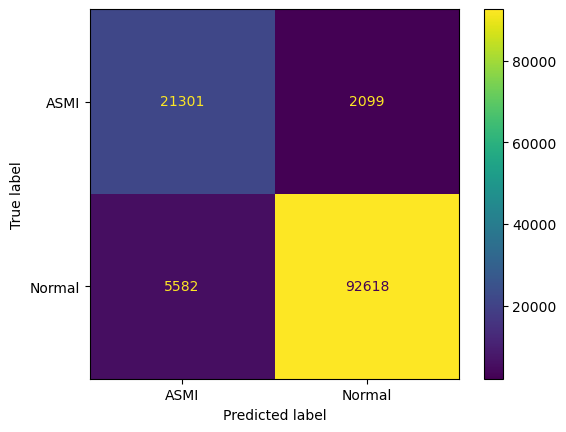

In [21]:
y_pred_tensor = torch.cat(y_pred).to('cpu')
y_true_tensor = torch.cat(y_true).to('cpu')

label_mapping = {'ASMI': 0, 'Normal': 1}

y_pred_numpy = y_pred_tensor.numpy()
y_true_numpy = y_true_tensor.numpy()

cm = confusion_matrix(y_true_numpy, y_pred_numpy)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['ASMI', 'Normal'])
disp.plot()
plt.show()

In [22]:
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
precision = TP / (TP + FP)

print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {precision:.4f}")

Sensitivity (Recall): 0.9432
Specificity: 0.9103
Precision: 0.9778


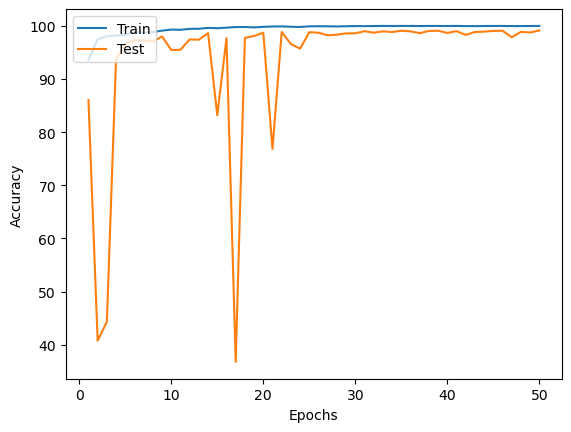

In [23]:
plt.plot(range(1,len(tr_acc)+1), tr_acc)
plt.plot(range(1,len(tr_acc)+1), valid_acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

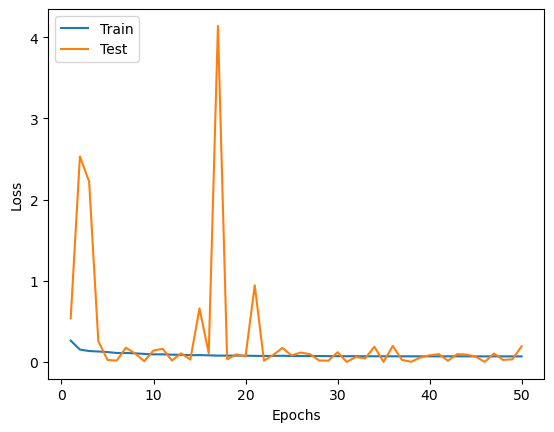

In [24]:
plt.plot(range(1,len(tr_acc)+1), tr_loss)
plt.plot(range(1,len(tr_acc)+1), valid_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()